# Efficient Frontier
### Pranay Jha

In [191]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import yfinance as yf

Scraping returns data and computing daily returns

In [181]:
tickers = ['NVDA', 'MSFT', 'AMZN']
returns = {}
for ticker in tickers:
    returns[ticker] = yf.Ticker(ticker)\
                        .history(period='1y')['Close']\
                        .pct_change()\
                        .dropna()
df_returns = pd.DataFrame(returns)
df_returns

,NVDA,MSFT,AMZN
Date,,,
2022-04-08 00:00:00-04:00,-0.044985,-0.014600,-0.021067
2022-04-11 00:00:00-04:00,-0.051992,-0.039432,-0.021614
2022-04-12 00:00:00-04:00,-0.018844,-0.011218,-0.002213
2022-04-13 00:00:00-04:00,0.032506,0.019712,0.031524
2022-04-14 00:00:00-04:00,-0.042562,-0.027084,-0.024653
...,...,...,...
2023-03-31 00:00:00-04:00,0.014388,0.014962,0.012647
2023-04-03 00:00:00-04:00,0.006768,-0.003711,-0.008520
2023-04-04 00:00:00-04:00,-0.018309,-0.000174,0.015038


Returns statistics

In [182]:
stats = {
    "E[r]": df_returns.mean(),
    "Var[r]": df_returns.var(),
    "\u03C3": df_returns.std(),
    "E[r]/\u03C3": df_returns.mean() / df_returns.std()
}
df_stats = pd.DataFrame(stats)
df_stats

,E[r],Var[r],σ,E[r]/σ
NVDA,0.001174,0.001468,0.038313,0.030631
MSFT,0.000146,0.000481,0.021921,0.006676
AMZN,-0.001283,0.000915,0.030256,-0.042400


Computing variance-covariance matrix of a given set of series
$$\Sigma = \frac{\mathbf{X^T X}}{n - 1}$$

In [183]:
def var_cov(X):
    n = len(X)
    return np.matmul(X.T, X)/(n - 1)

Variance-covariance matrix of daily returns

In [184]:
X = df_returns.to_numpy()
vc = var_cov(X)
vc

array([[0.0014693 , 0.00062324, 0.00080072],
       [0.00062324, 0.00048056, 0.00050045],
       [0.00080072, 0.00050045, 0.0009171 ]])

Computing portfolio statistics given weights, expected returns, and variance-covariance matrix
$$E[r]_p = \mathbf{w_p} \cdot \mathbf{r}$$
$$\sigma_p = \left(\mathbf{w \Sigma w^T}\right)^{\frac{1}{2}}$$

In [185]:
def port_stats(w, r, vc):
    er_p = np.dot(w, r)
    stddev_p = np.matmul(np.matmul(w, vc), w.T)**(1/2)
    return er_p, stddev_p

Equally-weighted portfolio statistics

In [186]:
w_eq = np.full(len(tickers), 1/len(tickers))
er_eq, stddev_eq = port_stats(w_eq, df_stats['E[r]'], vc)
print("E[r]: " + str(er_eq))
print("\u03C3: " + str(stddev_eq))
print("E[r]/\u03C3: " + str(er_eq/stddev_eq))

E[r]: 1.2352411808405088e-05
σ: 0.02731663809062552
E[r]/σ: 0.0004521937058076033


Monte Carlo simulation to construct Markowitz bullet using randomized weights

In [187]:
n = 2500
ports = {}
for ticker in tickers:
    ports[ticker] = np.empty(n)
ports['E[r]'] = np.empty(n)
ports['\u03C3'] = np.empty(n)
ports['E[r]/\u03C3'] = np.empty(n)

for i in range(n):
    rand_nums = np.random.rand(len(tickers))
    w_rand = rand_nums / rand_nums.sum()
    ports['E[r]'][i], ports['\u03C3'][i] = port_stats(w_rand, df_stats['E[r]'], vc)
    ports['E[r]/\u03C3'][i] = ports['E[r]'][i] / ports['\u03C3'][i]
    for j, ticker in enumerate(tickers):
        ports[ticker][i] = w_rand[j]
df_ports = pd.DataFrame(ports)
df_ports

,NVDA,MSFT,AMZN,E[r],σ,E[r]/σ
0,0.130359,0.634663,0.234978,-0.000056,0.023888,-0.002327
1,0.522956,0.241686,0.235358,0.000347,0.029871,0.011622
2,0.200955,0.380982,0.418062,-0.000245,0.026053,-0.009393
3,0.742242,0.050144,0.207614,0.000612,0.033968,0.018019
4,0.414621,0.548192,0.037187,0.000519,0.026957,0.019257
...,...,...,...,...,...,...
2495,0.240704,0.268100,0.491196,-0.000308,0.027249,-0.011318
2496,0.459096,0.450230,0.090674,0.000488,0.027925,0.017488
2497,0.269501,0.300607,0.429892,-0.000191,0.027120,-0.007051
2498,0.485537,0.346095,0.168368,0.000404,0.028786,0.014051


Plotting Markowitz bullet

In [188]:
fig = px.scatter(df_ports,
                 x='\u03C3',
                 y='E[r]',
                 color='E[r]/\u03C3',
                 hover_data=[ticker for ticker in tickers])
fig.show()

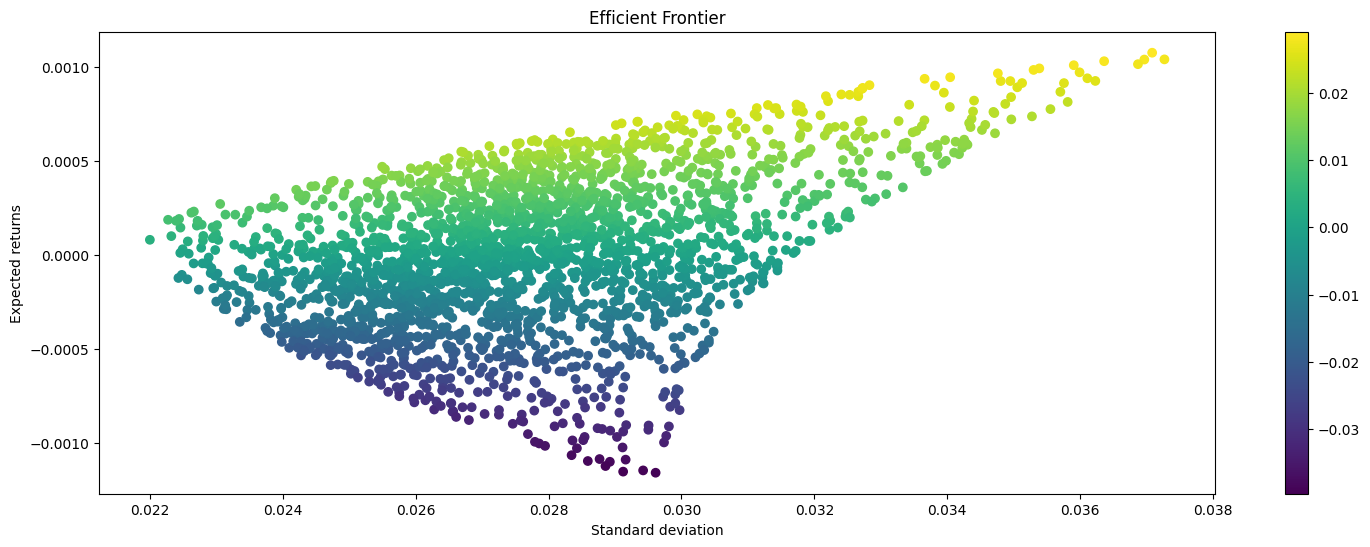

In [199]:
plt.figure(figsize=(18, 6))
plt.title('Efficient Frontier')
plt.xlabel('Standard deviation')
plt.ylabel('Expected returns')
plt.scatter(df_ports['\u03C3'], df_ports['E[r]'], c=df_ports['E[r]/\u03C3'], cmap='viridis')
plt.colorbar()
plt.show()

Locating portfolios with minimum variance and maximum (modified) Sharpe

In [189]:
min_var = df_ports.iloc[df_ports['\u03C3'].idxmin()]
min_var

NVDA      0.002529
MSFT      0.950350
AMZN      0.047121
E[r]      0.000082
σ         0.022002
E[r]/σ    0.003709
Name: 1546, dtype: float64

In [190]:
max_sharpe = df_ports.iloc[df_ports['E[r]/\u03C3'].idxmax()]
max_sharpe

NVDA      0.938150
MSFT      0.039029
AMZN      0.022821
E[r]      0.001077
σ         0.037084
E[r]/σ    0.029054
Name: 1954, dtype: float64